# Notebook 2: ETF Close Price Prediction by Using Linear Regression

## Objectives
- Per the Business Requirement, we will divise a Machine Learning Linear Regression Model and associated metrics to predict the ETF Close price
- We will also use the results to see which Hypotheses are satisfied through our chosen validation method (above)
- Just out of curiosity, we also want to ask ourselves how much Feature Engineering affects the outcome here

## Input(s)
- ETF Ticker files (both with and without features)

## Output(s)
- Linear Regression metrics (R-squared and MAE - Mean Absolute Error)
- Various plots associated with the above metrics

## Section 1: A Reminder of the results we're trying to achieve and the core Hypotheses for this project
- <mark>Acceptable R-Squared score: over 90%</mark>

### Core Hypotheses (what we intend to prive)
- H0: Machine Learning ETF (H2 and H3) predictions accuracy relies heavily on macroeconomic data. 
- H1: Most ETF close prices and price direction are heavily influenced by GDP data figures
- <mark>H2: Most ETF close prices are accurately predicted using just macroeconomic data</mark>
- H3: Most ETF price directions are accurately predicted, again using just macroeconomic data

### Core Hypotheses Validation Methods (what we will  use to prove the above)
- V0: Parallel testing datasets with and without macroeconomic data using Classical Machine Learning
- V1: Classical Machine Learning – Feature Selection
- <mark>V2: Classical Machine Learning – Linear Regression</mark>
- V3: Feature Engineering - Machine Learning – Classification by Random Forrest


## Section 2: Import Python Libraries

In [455]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

#for feature importance
from sklearn.preprocessing import StandardScaler

# For graph plotting style
plt.style.use('seaborn-v0_8-whitegrid')

#No System Warnings
import warnings
warnings.filterwarnings('ignore')

# Check the current working directory
import os
print(os.getcwd()) 

c:\Users\tishs\vscode-projects\etf-close-price\jupyter_notebooks


## Section 3: Get User Input & Run the Code to get the Results
- Trying to make this part more 'interactive'
- Using the sample Ticker names below, user is asked to provide a Ticker name e.g. SKY

### Reasoning behind this approach: 
Trying the generalise the code, so that we can run through the list of ETFs from the business requirement without having to write code for each one - favouring code-reuse

| **Sample Ticker Name:** |
| --- |
| 'SKY', 'VOO', 'IVV', 'VTI', 'ITOT' |
| 'QQQ', 'QQQE' |
| 'IWM', 'IWF', 'IWD', 'MDY' |
| 'XLK', 'XLF', 'XLE', 'XLV' |
| 'TLT', 'BND', 'HYG' |
| 'VEU', 'EFA' |

In [456]:
Ticker = "SKY" # Insert the ETF Ticker that you wish to test Here, e.g. "QQQE"

### <p style="text-align: center;">Afterwards, please click the "Run All" button above and select the desired Python Version to produce the test results</p>

## Section 4: Load the ETF sample files into Pandas dataframes and carry out basic checks before we continue
### Files Loaded -
1. ETF file WITHOUT new features (i.e. no Feature Enhancement; no Feature Engineering)
2. ETF file WITH new features (BOTH Feature Enhancement AND Feature Engineering have been applied)
3. FRED Macroeconomic Indicator dataset 

Note: This goes against the 'use-lower-case only' file nameing convention BUT it's simpler to keep it this way, so that I can use the Ticker name (always in upper-case) to pull back the files needed

In [457]:
ETF_filename_no_features = f"..//resources/raw_files/yfinance/{Ticker}_1d_data.csv"                 # Path to raw data without features - keeping the Ticker name as uppercase for consistency
ETF_filename_features = f"..//resources/featured_files/yfinance/{Ticker}_1d_features.csv"           # Path to featured data - keeping the Ticker name as uppercase for consistency  

feat_df = pd.read_csv(ETF_filename_features)                                                        #load featured data into dataframe
no_feat_df = pd.read_csv(ETF_filename_no_features)                                                  #load raw data (no features) into dataframe

In [458]:
no_feat_df.shape, feat_df.shape                                                                     #Check the shapes of the dataframes are the same

((1507, 8), (1507, 31))

In [459]:
feat_df.isnull().sum(), no_feat_df.isnull().sum()                                                   #quick Check for null values in both dataframes - want the data as clean as possible  

(Date                       0
 Ticker                     0
 Open                       0
 High                       0
 Low                        0
 Close                      0
 Volume                     0
 Dividends                  0
 Stock Splits               0
 Price_Movement             0
 Price_Movement_Pct         0
 Year                       0
 Month                      0
 Day                        0
 Day_of_Year                0
 Day_of_Week                0
 quarter                    0
 Close_lag1                 0
 Close_lag3                 0
 Close_lag5                 0
 Close_lag7                 0
 Close_lag14                0
 Close_lag21                0
 Close_lag28                0
 Close_lag365               0
 Month_Sin                  0
 Month_Cos                  0
 Dayofweek_Sin              0
 Dayofweek_Cos              0
 Price_Movement_Category    0
 Price_Movement_Code        0
 dtype: int64,
 Date            0
 Open            0
 High            

In [460]:
#bring in macroeconomic data before merging with the ETF data we introduced earlier
econ_data_df = pd.read_csv(r"../resources/raw_files/fred/fred_macro_data.csv")              #load macroeconomic data into dataframe

In [461]:
econ_data_df.shape

(2190, 47)

In [462]:
econ_data_df.head()

,Date,GDP,CPI_Inflation,Average_price_of_eggs,Average_price_of_electricity,Leading_Index_for_US,NBER_Recession_Indicator,Producer_Price_Index,5-Year_Breakeven_Inflation,Natural_Rate__of_Unemployment_(est.),...,U_Mich_Consumer_Sentiment,Chicago_Fed_National_Activity_Index,CBOE_Volatility_Index (VIX),Chicago_Fed_National_Financial_Conditions,Equity_Vol_Tracker:_Broad Macro,10Y-3M_Treasury_Spread,Moodys_BAA_Corporate_Bond_Yield,Capacity_Utilization:_Manufacturing,1-Month_Treasury_Bill,WTI_Crude_Oil_Price
0,2020-01-03,21751.238,259.127,1.461,0.134,1.57,0.0,199.3,1.85,4.403836,...,99.8,-0.25,14.02,-0.56599,5.66965,0.28,1.99,208.0,1.52,63.00
1,2020-01-04,21751.238,259.127,1.461,0.134,1.57,0.0,199.3,1.85,4.403836,...,99.8,-0.25,14.02,-0.56599,5.66965,0.28,1.99,208.0,1.52,63.00
2,2020-01-05,21751.238,259.127,1.461,0.134,1.57,0.0,199.3,1.85,4.403836,...,99.8,-0.25,14.02,-0.56599,5.66965,0.28,1.99,208.0,1.52,63.00
3,2020-01-06,21751.238,259.127,1.461,0.134,1.57,0.0,199.3,1.81,4.403836,...,99.8,-0.25,13.85,-0.56599,5.66965,0.25,2.02,208.0,1.54,63.27
4,2020-01-07,21751.238,259.127,1.461,0.134,1.57,0.0,199.3,1.81,4.403836,...,99.8,-0.25,13.79,-0.56599,5.66965,0.29,2.03,208.0,1.52,62.70


In [463]:
merged_feat = feat_df.merge(econ_data_df, on="Date", how="inner")                           #merge featured ETF data with macroeconomic data on Date column
merged_no_feat = no_feat_df.merge(econ_data_df, on="Date", how="inner")                     #merge raw ETF data with macroeconomic data on Date column

In [464]:
feat_df.shape, no_feat_df.shape   

((1507, 31), (1507, 8))

In [465]:
 
merged_feat.shape, merged_no_feat.shape                                                     #Check the pullback shapes after merging are the same as before (above)

((1506, 77), (1506, 54))

## Notes and Observations:
- There was more records in the FRED Macroeconomic Data file (2190 records)
- ETF Market Data file had 1507 records before merging with FRED file
- The merged file (using inner join in date) has 1506 records - essentially this means a row difference - we'll need to investigate this if there's time or mark it on the bug section for now

In [466]:
merged_feat.head(), merged_no_feat.head()                                                   #Check the head of both merged dataframes - see if files are populated correctly

(         Date Ticker       Open       High        Low      Close  Volume  \
 0  2020-01-03    SKY  31.639999  32.110001  30.850000  32.060001  440100   
 1  2020-01-06    SKY  31.670000  32.209999  31.320000  32.049999  270600   
 2  2020-01-07    SKY  32.180000  32.230000  31.420000  31.719999  285100   
 3  2020-01-08    SKY  32.070000  33.049999  31.799999  32.049999  335200   
 4  2020-01-09    SKY  32.230000  33.029999  32.230000  32.840000  368200   
 
    Dividends  Stock Splits  Price_Movement  ...  U_Mich_Consumer_Sentiment  \
 0        0.0           0.0        0.420002  ...                       99.8   
 1        0.0           0.0        0.379999  ...                       99.8   
 2        0.0           0.0       -0.460001  ...                       99.8   
 3        0.0           0.0       -0.020000  ...                       99.8   
 4        0.0           0.0        0.610001  ...                       99.8   
 
    Chicago_Fed_National_Activity_Index  CBOE_Volatility_Ind

In [467]:
merged_no_feat.info(), merged_feat.info()                                                     #Check the info of both merged dataframes - check on the non-nulls and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506 entries, 0 to 1505
Data columns (total 54 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Date                                       1506 non-null   object 
 1   Open                                       1506 non-null   float64
 2   High                                       1506 non-null   float64
 3   Low                                        1506 non-null   float64
 4   Close                                      1506 non-null   float64
 5   Volume                                     1506 non-null   int64  
 6   Dividends                                  1506 non-null   float64
 7   Stock Splits                               1506 non-null   float64
 8   GDP                                        1506 non-null   float64
 9   CPI_Inflation                              1506 non-null   float64
 10  Average_price_of_eggs   

(None, None)

In [468]:
drop_list_feat =merged_feat.select_dtypes(include=['object']).columns.to_list()                             #create a list of columns with object data types to drop from featured dataframe
drop_list_no_feat = merged_no_feat.select_dtypes(include=['object']).columns.to_list()                      #create a list of columns with object data types to drop from non-featured dataframe   

In [469]:
drop_list_feat, drop_list_no_feat                                                                           #we don't need string/object data types for regression analysis, and date has done its job as a merge key

(['Date', 'Ticker', 'Price_Movement_Category'], ['Date'])

In [470]:
# Drop the object data type columns from both dataframes - in preparation for regression analysis
merged_no_feat = merged_no_feat.drop(drop_list_no_feat,axis=1)
merged_feat = merged_feat.drop(drop_list_feat,axis=1)

In [471]:
# To be extra cautious, fill any remaining NaN values with 0 - as regression models cannot handle NaN values well!
merged_no_feat = merged_no_feat.fillna(0)
merged_feat = merged_feat.fillna(0)

## Section 5: Preparing Data for Machine Learning Model (Simple Linear Regression)

In [472]:
'''Prepare the data for regression analysis
 by separating the features (X) and target variable (Y)

 As per earlier EDA, we will predict the 'Close' price of the ETF using other available features.
 To not give the model an unfair advantage, we will drop 'Open', 'High', and 'Low' prices from the feature set.
 This was decided from our EDA process, as these prices are highly correlated with 'Close' price.
 Please refer to the EDA notebook for more details (Notebook: 1b_ETF_Price_Predictions_EDA.ipynb)
'''

X_no_feat = merged_no_feat.drop(['Close','Open', 'High', 'Low'], axis=1)                                    #drop 'Close', 'Open', 'High', and 'Low' columns from 'no feature' set
Y_no_feat = merged_no_feat['Close']                                                                         #set target variable as 'Close' price

X_feat = merged_feat.drop(['Close','Open', 'High', 'Low'], axis=1)                                          #same as above, but for featured dataset
Y_feat = merged_feat['Close']                                                                               #same as above, but for featured dataset

## Section 6: Split the Data into Training and Testing Sets
- As per the norm, we split it 80% for training leaving 20% for testing

In [473]:
#Casecade the train-test split for both datasets (with and without features)

X_train_no_feat, X_test_no_feat, y_train_no_feat, y_test_no_feat = train_test_split(                        #output variables for no feature dataset
    X_no_feat, 
    Y_no_feat, 
    test_size=0.2,                                                                                          #20% reserved for testing
    random_state=42                                                                                         #random state for reproducibility   
)

print(f"Training on {len(X_train_no_feat)} ETF prices - no feature engineering")                            #audit trail print statements
print(f"Testing on {len(X_test_no_feat)} ETF prices - no feature engineering")                              #audit trail print statements

X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(                                    #output variables for featured dataset
    X_feat, 
    Y_feat, 
    test_size=0.2,                                                                                          #see above   
    random_state=42                                                                                         #see above
)

print(f"\nTraining on {len(X_train_feat)} ETF prices - with feature engineering")                           #see above
print(f"Testing on {len(X_test_feat)} ETF prices - with feature engineering")                               #see above

Training on 1204 ETF prices - no feature engineering
Testing on 302 ETF prices - no feature engineering

Training on 1204 ETF prices - with feature engineering
Testing on 302 ETF prices - with feature engineering


## Section 7: Training the Regression Model and Using it to Generate Predictions

In [474]:
# Train the regression model
model_no_feat = LinearRegression()                                                                          #initialize linear regression model for no feature dataset
model_no_feat.fit(X_train_no_feat, y_train_no_feat)                                                         #fitting the model to the training data

model_feat = LinearRegression()                                                                             #initialize linear regression model for featured dataset
model_feat.fit(X_train_feat, y_train_feat)                                                                  #fitting the model to the training data

# Make predictions
y_pred_no_feat = model_no_feat.predict(X_test_no_feat)                                                      #predicting the ETF 'Close' prices for the test set without features
y_pred_feat = model_feat.predict(X_test_feat)                                                               #predicting the ETF 'Close' prices for the test set with features   

In [475]:
y_pred_no_feat, y_pred_feat                                                                                 #reviewing the predictions made by both models - checking for any obvious anomalies

(array([ 60.45109683,  81.1390477 ,  50.38710978,  56.77780215,
         57.51544218,  88.96421086,  31.48960398,  75.44367519,
         52.95641521,  73.79070651,  76.65941478,  81.36001338,
         43.13123201,  64.17287401,  69.93251065,  80.37464584,
         58.68137422,  65.71639456,  74.12629867,  59.18727961,
         81.13058018,  77.67900437,  58.40344013,  49.31930134,
         59.82234755,  80.83802688,  95.01679621,  61.21607798,
         77.02159535,  78.57501059,  67.00534818,  68.78465609,
         96.49627551,  26.05437133,  53.94084052,  71.19764257,
         43.24618776,  52.19181186,  81.43953437,  94.82324185,
         89.60962867,  53.73446507,  72.61085548,  17.3611389 ,
         83.85825527,  60.00859818,  83.94781635,  37.34119018,
         49.51763724,  11.03397807,  52.24411183,  60.45359341,
         34.57953523,  69.84443933,  70.41425796,  55.64208665,
         54.19012328,  67.85553652,  56.45016696,  80.07664174,
         11.25224041,  15.90939116,  41.

## Section 8: Looking at the Underlying Linear Regression Metrics Produced by our Model & What They Tell Us

### Chosen Metrics & what they mean:
- Mean Absolute Error (MAE): Or the average error size (signs ignored here) - answers the question of how far the model's prediction were off by (from true/actual values) - lower is better
- R-Squared: How much the target's variation is explained by the ML regression model - nearest to 1 is best, as a perfect 1 (or 100%) meaning the model is able to explain ALL variations


In [476]:
# Calculate metrics - using the test sets and predicted values generated from above steps
mae_no_feat = mean_absolute_error(y_test_no_feat, y_pred_no_feat)                                  #Mean Absolute Error for no feature dataset
r2_no_feat = r2_score(y_test_no_feat, y_pred_no_feat)                                              #R² Score for no feature dataset
mae_feat = mean_absolute_error(y_test_feat, y_pred_feat)                                           #Mean Absolute Error for featured dataset
r2_feat = r2_score(y_test_feat, y_pred_feat)                                                       #R² Score for featured dataset

# Output the evaluation metrics - print these out before we go to visualizations
print(f"{Ticker}: Mean Absolute Error (MAE)")
print()
print(f"   Your MAE : USD {mae_no_feat:,.0f} (without feature engineering) ; USD {mae_feat:,.0f} (with feature engineering)")
print()
print("   What it means: On average, our predictions are off by this much")
print("   Goal: Lower is better!")
print()
print(f"{Ticker}: R² Score (R-squared)")
print()
print(f"   Your R² : {r2_no_feat:.1%} (without feature engineering) ; {r2_feat:.1%} (with feature engineering)")
print()
print("   What it means: How much of the ETF's Close price variation we can explain")
print("   Goal: Higher is better (100% = perfect, 0% = terrible)")

SKY: Mean Absolute Error (MAE)

   Your MAE : USD 4 (without feature engineering) ; USD 1 (with feature engineering)

   What it means: On average, our predictions are off by this much
   Goal: Lower is better!

SKY: R² Score (R-squared)

   Your R² : 95.4% (without feature engineering) ; 99.8% (with feature engineering)

   What it means: How much of the ETF's Close price variation we can explain
   Goal: Higher is better (100% = perfect, 0% = terrible)


## Notes & Observations (for ETF Ticker "IWF"):
- Introducing new features to ETF Market data (undecided here if enhanced or engineered) definitely impacts the prediction accuracy
- MAE went from Close Price of USD 6 down to USD 2 - remember smaller MAE is better - so adding features caused a MAE reduction of USD or 67%
- Same for R-Squared - this has been impacted by the inclusion of new features - as more of the target variation is explainable - this went from 99.3% to 99.9% - meaning the model is closer to explaining all target variations

- <mark>Hypothesis H0</mark> - although there is a reliance on macroeconomic indicators (H0 confirmed) - there's also a way of enhancing the model through new features
- <mark>Hypothesis H2</mark> - this is also validated, as without new features we were able to breach the 90% threshold - again however we would point out there's also a chance to fine-tune the model further through adding new features 

## Sector 9: Data Visualisation of ML Linear Regression Model Results (Featured vs No-Featured datasets)
- Just easier to see the difference visually
- Graphs provided are scatter (Matplotlib) and line (Matplotlib) plots

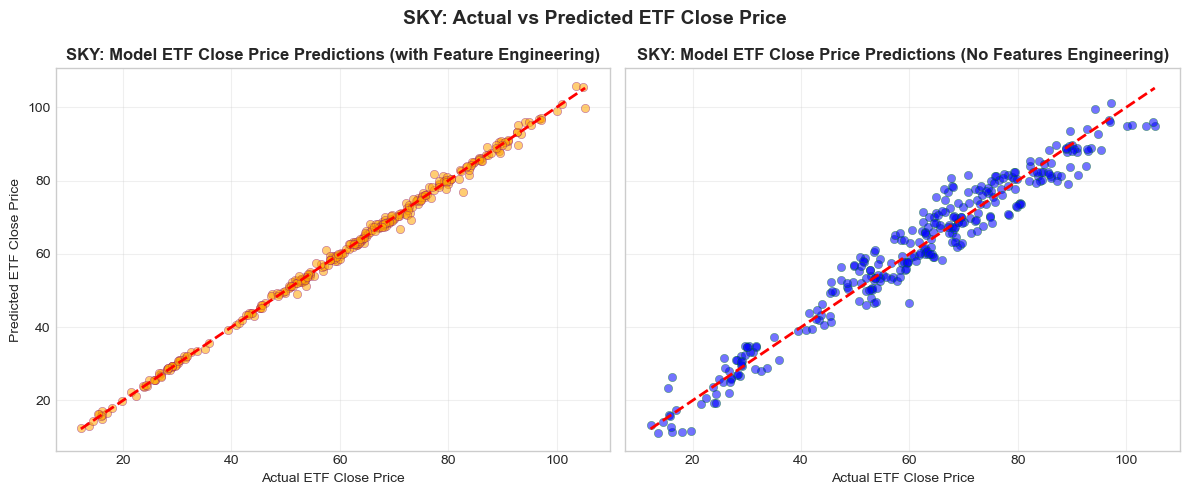

In [477]:
fig, (ax1, ax2) = plt.subplots(1, 2,                                                                                    # Create 2 subplots side by side
                               figsize=(12, 5),                                                                         # Set figure size - please adjust here as needed
                               sharey=True)                                                                             # Share Y-axis ( for a better comparison)

fig.suptitle("{ticker}: Actual vs Predicted ETF Close Price".format(ticker=Ticker),                                     # Title for the entire figure - that dynamically includes the Ticker
             fontsize=14,                                                                                               # Font size for the title
             fontweight="bold")                                                                                         # Bold font set for the title

# Left subplot: With Feature Engineering
ax1.scatter(                                                                                                            #scatter plot for featured dataset
    y_test_feat,                                                                                                        #actual 'Close' prices from test set
    y_pred_feat,                                                                                                        #model predicted 'Close' prices from logic regression    
    alpha=0.55,                                                                                                         #transparency level for better visualization    
    color="orange",                                                                                                     #scatter plot color scheme chosen to highlight against the linear line
    edgecolors="purple",                                                                                                #edge color for better visibility
    linewidths=0.4,                                                                                                     #line width for better visibility
    marker="o"                                                                                                          #marker set as circular
)
ax1.plot(                                                                                                               #linear regression 'best fit' line using results above
    [y_test_feat.min(), 
     y_test_feat.max()],
    [y_test_feat.min(), 
     y_test_feat.max()],
    linestyle="--",                                                                                                     #line style - as red and dotted/broken
    linewidth=2,
    color="red"
)

ax1.set_xlabel("Actual ETF Close Price")                                                                                #setting the graph axis labels & title
ax1.set_ylabel("Predicted ETF Close Price")
ax1.set_title("{ticker}: Model ETF Close Price Predictions (with Feature Engineering)".format(ticker=Ticker), 
              fontweight="bold")
ax1.grid(True, 
         alpha=0.3)                                                                                                     #graph grid and transparency settings

# Right subplot: Without Feature Engineering
ax2.scatter(                                                                                                            #same as the above comments but with slight modifications (different colours to contrast)
    y_test_no_feat,
    y_pred_no_feat,
    alpha=0.55,
    color="blue",
    edgecolors="green",
    linewidths=0.4,
    marker="o"
)
ax2.plot(
    [y_test_no_feat.min(), 
     y_test_no_feat.max()],
    [y_test_no_feat.min(), 
     y_test_no_feat.max()],
    linestyle="--",
    linewidth=2,
    color="red"
)

ax2.set_xlabel("Actual ETF Close Price")
ax2.set_title("{ticker}: Model ETF Close Price Predictions (No Features Engineering)".
              format(ticker=Ticker), 
              fontweight="bold")
ax2.grid(True, 
         alpha=0.3)

plt.tight_layout()
plt.show()

## Notes & Observations (applies to this ETF (IWF) as well as most others):
- With new features - the plot markers/points are closer to the line of best fit - more accurate Close ETF Price predictions
- Without new features - markers still congregate near enough to the line of best, however the distribution is different somewhat and less 'linear'
- Hypotheses H0 and H2 are still valid and satisfied here 

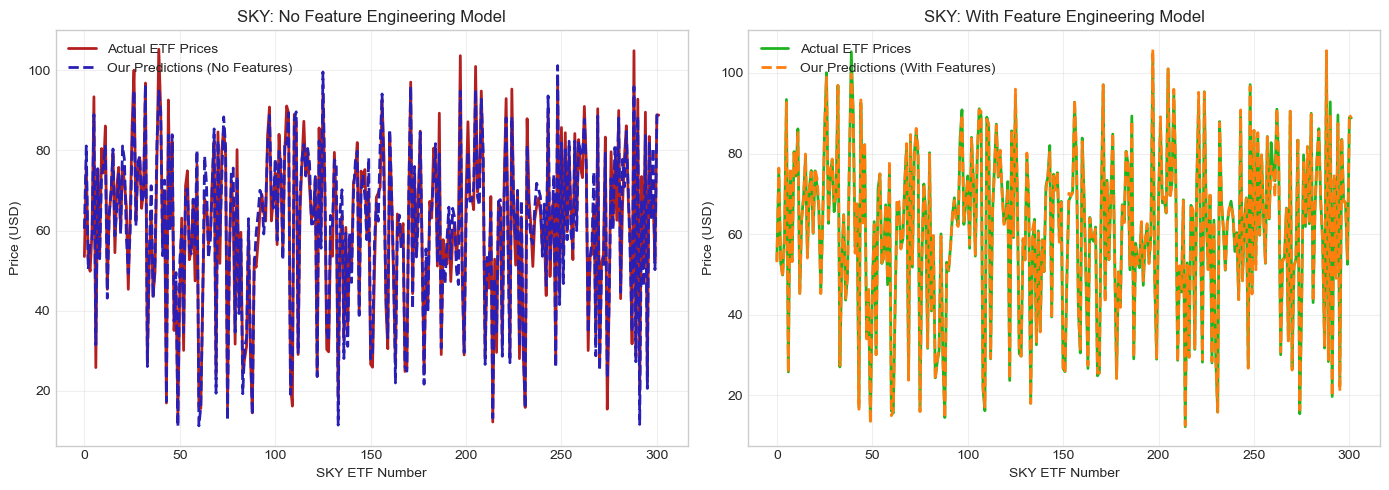

In [478]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))                                               # Create 2 subplots side by side - as before for comparison of actual vs predicted prices

# Common x-axis
x_axis = range(len(y_test_no_feat))

# Left: No Feature Engineering (click on the colours to change them as you like!)
ax1.plot(x_axis,                                                                                    #plot for no feature dataset
         y_test_no_feat.values,                                                                     #review actual 'Close' prices from test set
         color="#b41f1f", linestyle='-',                                                          #customize the line colour and style
         linewidth=2,                                                                               #set size of linewidth
         label='Actual ETF Prices'                                                                  #label for legend
         )

ax1.plot(x_axis, 
         y_pred_no_feat,                                                                            #review predicted 'Close' prices from test set
         color="#291fb4", linestyle='--',                                                         #customize the line colour and style
         linewidth=2,                                                                               #set size of linewidth
         label='Our Predictions (No Features)'                                                      #label for legend
         )
ax1.set_xlabel('{ticker} ETF Number'.format(ticker=Ticker))                                         #dynamic x axis labels using ticker names embedded
ax1.set_ylabel('Price (USD)')                                                                       #setting the y axis lables
ax1.set_title('{ticker}: No Feature Engineering Model'.format(ticker=Ticker))                       #dynamic title using ticker names embedded
ax1.legend()
ax1.grid(True,                                                                                      #grid and transparency settings
         alpha=0.3)

# Right: With Feature Engineering (click on the colours to change them as you like!)                #comments as above with slight variations (to contrast)
ax2.plot(x_axis, y_test_feat.values,
         color="#1fb41f", 
         linestyle='-', 
         linewidth=2,
         label='Actual ETF Prices')

ax2.plot(x_axis, y_pred_feat,
         color='#ff7f0e', linestyle='--', 
         linewidth=2,
         label='Our Predictions (With Features)')
ax2.set_xlabel('{ticker} ETF Number'.format(ticker=Ticker))
ax2.set_ylabel('Price (USD)')
ax2.set_title('{ticker}: With Feature Engineering Model'.format(ticker=Ticker))
ax2.legend()
ax2.grid(True, 
         alpha=0.3)

plt.tight_layout()
plt.show()

## Notes and Observations:
- Above tells us that predicted ETF Close prices GENERALLY maps back to actual ETF Close prices
- Having said this, it's not a 100% match, with some over and under-predictions - as there are some areas where the prediction are higher and lower than the actual prices
- Again, as we know from above there is still the MSE value to consider and R-Square is NEAR a perfect score of 1 but we're not quite there.
- Would be a good idea, if we have the time, to run ALL ETF market share for all tickers - pulling back by using just macroeconomic indicators as one isolated dataset against JUST the actual Close prices 

## Section 10: Feature Importance Analysis
- Running the linear regression model again BUT with scaled data (for sake of comparability of FRED Indicator dataset)
- Using RMSE metric instead of MAE = uses the same units for errors (like MAE - so in our case USD, as its the price of US-based ETFs from business requirements) - like MAE scores, smaller is better!
- Will run the models in parallel - like above
- Will check the same results as before using new scatter plot of Actual Price vs Prediction
- Finally will show the top 10 Feature Importance (or Features that influence the model's price prediction powers the most)

In [479]:
# Cascading Feature Importance Analysis (building two new linear models) - making the features comparable by scaling (standardization of FRED macroeconomic features)
scaler_no_feat = StandardScaler()
X_train_scaled_no_feat = scaler_no_feat.fit_transform(X_train_no_feat)                                  #fit and transform the training data - no feature dataset
X_test_scaled_no_feat = scaler_no_feat.transform(X_test_no_feat)                                        #transform the test data - no feature dataset

scaler_feat = StandardScaler()
X_train_scaled_feat = scaler_feat.fit_transform(X_train_feat)                                            #fit and transform the training data - featured dataset
X_test_scaled_feat = scaler_feat.transform(X_test_feat)                                                  #transform the test data - featured dataset

In [480]:
# Train the regression models again on the scaled data

#model 1 - no features
lr_model_no_feat = LinearRegression()                                                                    #initialize linear regression model for no feature dataset
lr_model_no_feat.fit(X_train_scaled_no_feat, y_train_no_feat)                                            #fitting the model to the training data

#model 2 - with features
lr_model_feat = LinearRegression()                                                                       #initialize linear regression model for featured dataset
lr_model_feat.fit(X_train_scaled_feat, y_train_feat)                                                     #fitting the model to the training data    

LinearRegression()

In [481]:
#model 1 - no features 
y_pred_no_feat = lr_model_no_feat.predict(X_test_scaled_no_feat)
rmse_no_feat = np.sqrt(np.mean((y_test_no_feat - y_pred_no_feat)**2))
print(f"Linear Regression RMSE (no features): USD {rmse_no_feat:.2f}")

#model 2 - with features
y_pred_feat = lr_model_feat.predict(X_test_scaled_feat)
rmse_feat = np.sqrt(np.mean((y_test_feat - y_pred_feat)**2))
print(f"Linear Regression RMSE (with features): USD {rmse_feat:.2f}")

Linear Regression RMSE (no features): USD 4.51
Linear Regression RMSE (with features): USD 1.04


In [482]:
#Puts all the Feature Importances into arrays for both models

#model 1 - no features
coef_importance_no_feat = np.abs(lr_model_no_feat.coef_)
feature_names_no_feat = X_no_feat.columns.tolist() if hasattr(X_no_feat, 'columns') else [f'Feat_{i}' for i in range(X_no_feat.shape[1])]

#model 2 - with features
coef_importance_feat = np.abs(lr_model_feat.coef_)
feature_names_feat = X_feat.columns.tolist() if hasattr(X_feat, 'columns') else [f'Feat_{i}' for i in range(X_feat.shape[1])]

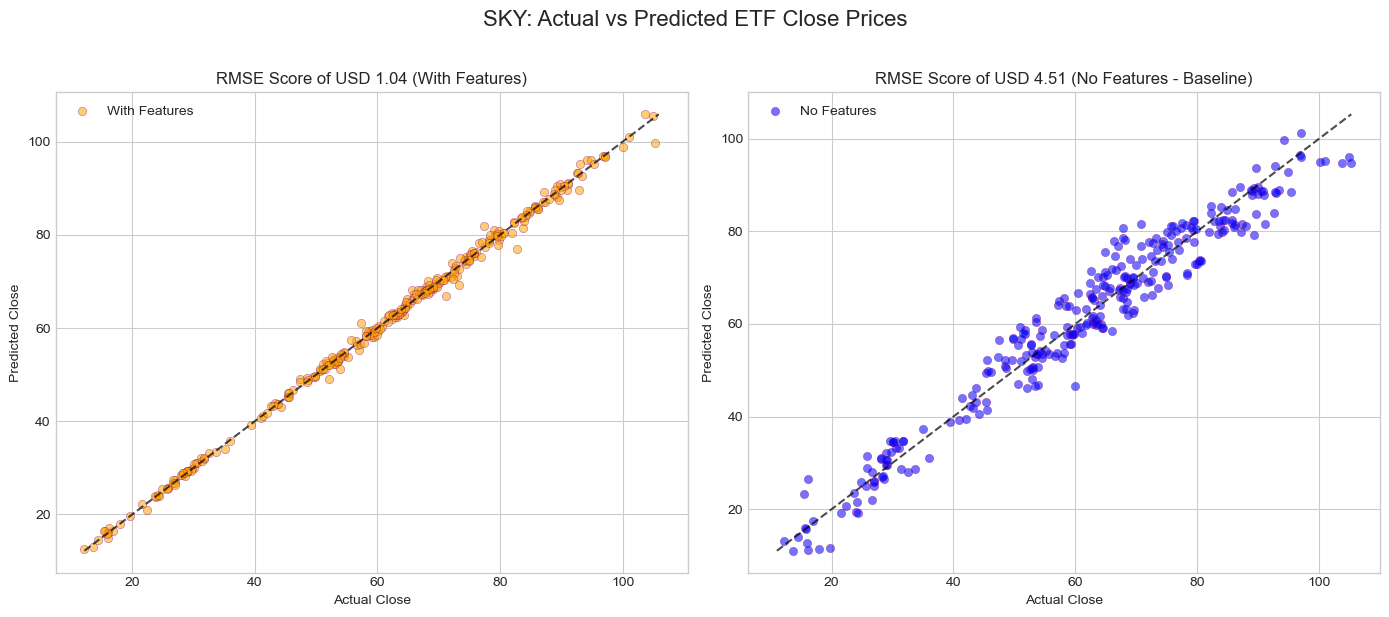

In [485]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))                           # Code comments as per earlier scatter plots

# Featured model (your orange code)
ax1.scatter(
    y_test_feat, 
    y_pred_feat,            
    alpha=0.55, 
    color="orange", 
    edgecolors="purple", 
    linewidths=0.4, 
    marker="o",
    label="With Features"
)

# Line of best fit
min_val1 = min(y_test_feat.min(),
                y_pred_feat.min())
max_val1 = max(y_test_feat.max(), 
               y_pred_feat.max())
ax1.plot([min_val1, 
          max_val1], 
          [min_val1, 
           max_val1], 
           "k--", 
           alpha=0.7)
ax1.set_xlabel("Actual Close")
ax1.set_ylabel("Predicted Close")
ax1.set_title("RMSE Score of USD {rmse_feat:.2f} (With Features)".format(rmse_feat=rmse_feat))
ax1.legend()

# No features baseline (blue/purple)
ax2.scatter(
    y_test_no_feat, 
    y_pred_no_feat,      
    alpha=0.55, 
    color="blue", 
    edgecolors="purple", 
    linewidths=0.4, 
    marker="o",
    label="No Features"
)

# Line of best fit
min_val2 = min(y_test_no_feat.min(),
                y_pred_no_feat.min())
max_val2 = max(y_test_no_feat.max(), 
               y_pred_no_feat.max())
ax2.plot([min_val2, 
          max_val2], 
          [min_val2, 
           max_val2], 
           "k--", 
           alpha=0.7)

ax2.set_xlabel("Actual Close")
ax2.set_ylabel("Predicted Close")
ax2.set_title("RMSE Score of USD {rmse_no_feat:.2f} (No Features - Baseline)".format(rmse_no_feat=rmse_no_feat))
ax2.legend()

#show plot
plt.suptitle("{ticker}: Actual vs Predicted ETF Close Prices".format(ticker=Ticker), fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

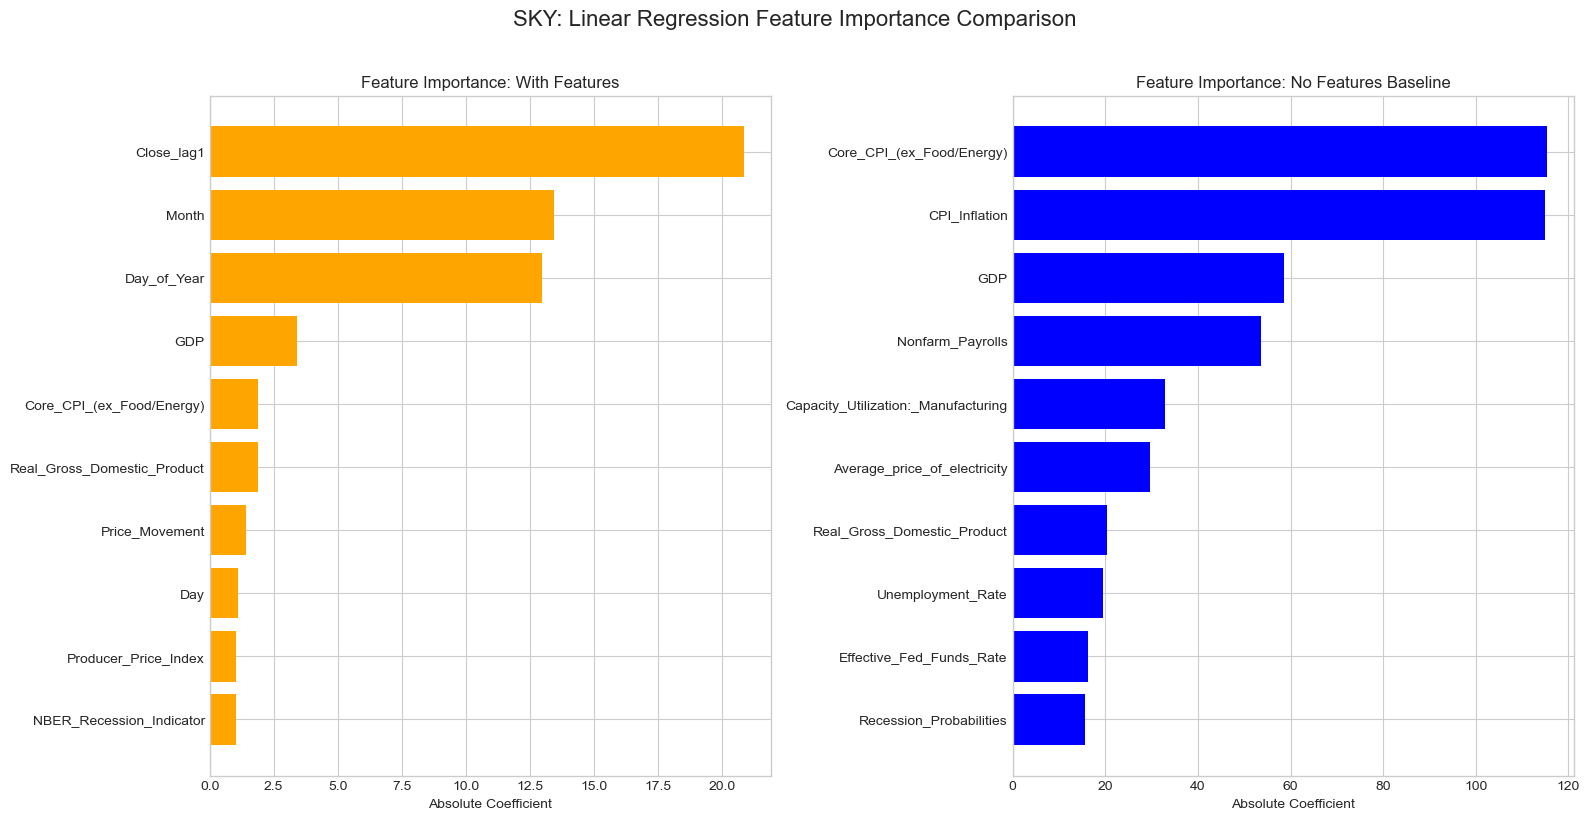

In [484]:
# Example data (replace with your actual values)
no_feat_importances = np.abs(lr_model_no_feat.coef_)                                # no_feat coefs
feat_importances = np.abs(lr_model_feat.coef_)                                      # feat coefs

no_feat_names = X_no_feat.columns.tolist()                                          #converts the column names to a list - no features
feat_names = X_feat.columns.tolist()                                                #converts the column names to a list - features    

# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))                               # Create 2 subplots side by side for better comparison

# RIGHT: Featured model
indices1 = np.argsort(feat_importances)[::-1][:10]                                  # Get the indices of the top 10 important features (rearranged in descending order)
ax1.barh(range(len(indices1)), 
         feat_importances[indices1], 
         color='orange')
ax1.set_yticks(range(len(indices1)))
ax1.set_yticklabels([feat_names[i] for i in indices1])
ax1.set_xlabel('Absolute Coefficient')
ax1.set_title('Feature Importance: With Features')
ax1.invert_yaxis()

# LEFT: No features baseline
indices2 = np.argsort(no_feat_importances)[::-1][:10]                               # as above for no features
ax2.barh(range(len(indices2)), 
         no_feat_importances[indices2], 
         color='blue')
ax2.set_yticks(range(len(indices2)))
ax2.set_yticklabels([no_feat_names[i] for i in indices2])
ax2.set_xlabel('Absolute Coefficient')
ax2.set_title('Feature Importance: No Features Baseline')
ax2.invert_yaxis()

plt.suptitle('{ticker}: Linear Regression Feature Importance Comparison'.format(ticker=Ticker), fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Notes & Observations
- Here we see from Feature Importance (above) - which features the model is using to predict the ETF Close prices, we've limited to the top 10 Features used
- Where Features are added: The linear regression model is using (in general) both enhanced features e.g. lag to get better predictions as well as some FRED indicators like GDP
- Where Features are excluded - the model has no choice but to rely more on FRED Macroeconomic indicators - but although its predictive powers are slightly diminished, it's still giving us R-Squared values over the accepted levels (90%)
- Therefore, to completely validate and satisfy or H0 and H2 Hypotheses, we need to look at just Macroeconomic Indicators vs ETF Closing Price and disregard the new features (both enhanced and engineered) altogether 